<!-- NAVIGATION -->
< [Chapter 11. God Spiked the Integers](11-god-spiked-the-integers.html) | [Chapter 13. Models With Memory](13-models-with-memory.html) >

In [0]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.distributions.transforms import OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_x64()

### Code 12.1

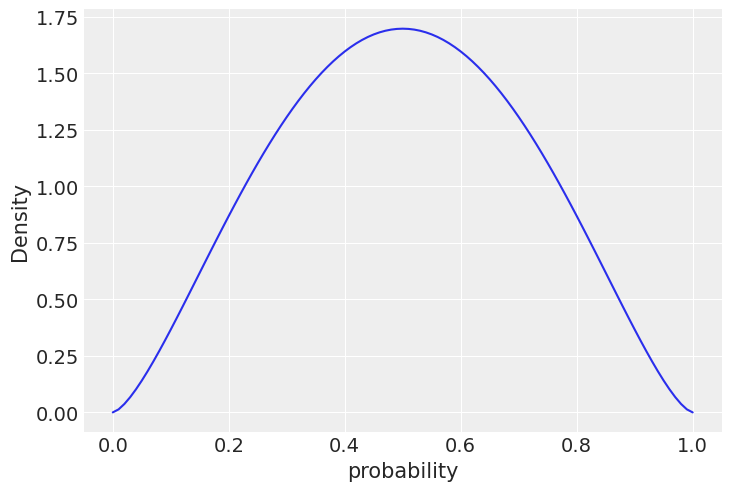

In [1]:
pbar = 0.5
theta = 5
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density")
plt.show()

### Code 12.2

In [2]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit
d["gid"] = (d["applicant.gender"] != "male").astype(int)
dat = dict(A=d.admit.values, N=d.applications.values, gid=d.gid.values)


def model(gid, N, A=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    phi = numpyro.sample("phi", dist.Exponential(1))
    theta = numpyro.deterministic("theta", phi + 2)
    pbar = expit(a[gid])
    numpyro.sample("A", dist.BetaBinomial(pbar * theta, (1 - pbar) * theta, N), obs=A)


m12_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_1.run(random.PRNGKey(0), **dat)

### Code 12.3

In [3]:
post = m12_1.get_samples()
post["theta"] = Predictive(m12_1.sampler.model, post)(random.PRNGKey(1), **dat)["theta"]
post["da"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.44      0.41     -0.44     -1.13      0.21   1489.43      1.00
      a[1]     -0.33      0.41     -0.32     -1.00      0.29   1549.34      1.00
        da     -0.11      0.57     -0.12     -0.94      0.88   1503.75      1.00
       phi      1.01      0.79      0.84      0.00      2.02   1433.60      1.00
     theta      3.01      0.79      2.84      2.00      4.02   1433.60      1.00



### Code 12.4

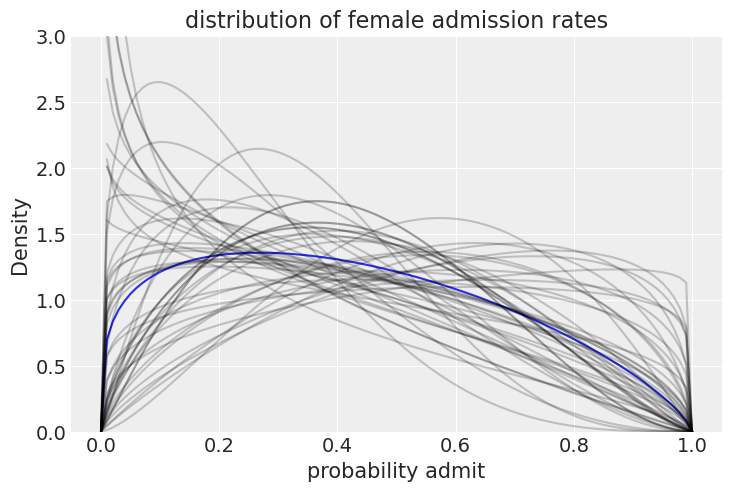

In [4]:
gid = 1
# draw posterior mean beta distribution
x = jnp.linspace(0, 1, 101)
pbar = jnp.mean(expit(post["a"][:, gid]))
theta = jnp.mean(post["theta"])
plt.plot(x, jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3))

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = expit(post["a"][i, gid])
    theta = post["theta"][i]
    plt.plot(
        x, jnp.exp(dist.Beta(p * theta, (1 - p) * theta).log_prob(x)), "k", alpha=0.2
    )
plt.title("distribution of female admission rates")
plt.show()

### Code 12.5

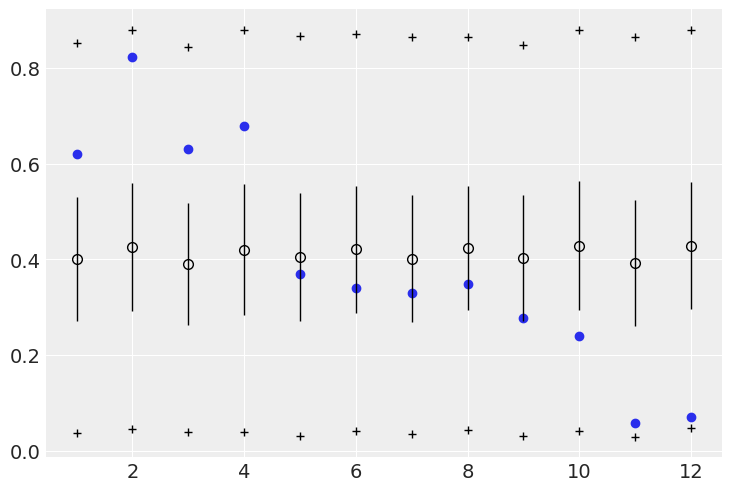

In [5]:
post = m12_1.get_samples()
admit_pred = Predictive(m12_1.sampler.model, post)(
    random.PRNGKey(1), gid=dat["gid"], N=dat["N"]
)["A"]
admit_rate = admit_pred / dat["N"]
plt.scatter(range(1, 13), dat["A"] / dat["N"])
plt.errorbar(
    range(1, 13),
    jnp.mean(admit_rate, 0),
    jnp.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), jnp.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), jnp.percentile(admit_rate, 94.5, 0), "k+")
plt.show()

### Code 12.6

In [6]:
Kline = pd.read_csv("../data/Kline.csv", sep=";")
d = Kline
d["P"] = d.population.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)

dat2 = dict(T=d.total_tools.values, P=d.population.values, cid=d.contact_id.values)


def model(cid, P, T):
    a = numpyro.sample("a", dist.Normal(1, 1).expand([2]))
    b = numpyro.sample("b", dist.Exponential(1).expand([2]))
    g = numpyro.sample("g", dist.Exponential(1))
    phi = numpyro.sample("phi", dist.Exponential(1))
    lambda_ = jnp.exp(a[cid]) * jnp.power(P, b[cid]) / g
    numpyro.sample("T", dist.GammaPoisson(lambda_ / phi, 1 / phi), obs=T)


m12_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_2.run(random.PRNGKey(0), **dat2)

### Code 12.7

In [7]:
# define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1  # average 1 manuscript per day

# sample one year of production
N = 365

with numpyro.handlers.seed(rng_seed=365):
    # simulate days monks drink
    drink = numpyro.sample("drink", dist.Binomial(1, prob_drink).expand([N]))

    # simulate manuscripts completed
    y = (1 - drink) * numpyro.sample("work", dist.Poisson(rate_work).expand([N]))

### Code 12.8

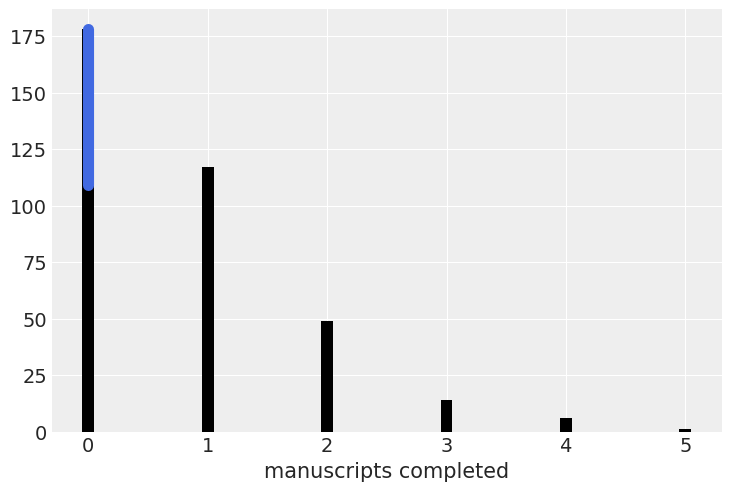

In [8]:
plt.hist(y, color="k", bins=jnp.arange(-0.5, 6), rwidth=0.1)
plt.gca().set(xlabel="manuscripts completed")
zeros_drink = jnp.sum(drink)
zeros_work = jnp.sum((y == 0) & (drink == 0))
zeros_total = jnp.sum(y == 0)
plt.plot([0, 0], [zeros_work, zeros_total], "royalblue", lw=8)
plt.show()

### Code 12.9

In [9]:
def model(y):
    ap = numpyro.sample("ap", dist.Normal(-1.5, 1))
    al = numpyro.sample("al", dist.Normal(1, 0.5))
    p = expit(ap)
    lambda_ = jnp.exp(al)
    numpyro.sample("y", dist.ZeroInflatedPoisson(p, lambda_), obs=y)


m12_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_3.run(random.PRNGKey(0), y=y)
m12_3.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al     -0.07      0.08     -0.07     -0.21      0.06    624.14      1.00
        ap     -1.81      0.50     -1.74     -2.48     -1.00    565.12      1.00

Number of divergences: 0


### Code 12.10

In [10]:
post = m12_3.get_samples()
print(jnp.mean(expit(post["ap"])))  # probability drink
print(jnp.mean(jnp.exp(post["al"])))  # rate finish manuscripts, when not drinking

0.15032704039980774
0.9373594290801954


### Code 12.11

In [11]:
def model(y):
    ap = numpyro.sample("ap", dist.Normal(-1.5, 1))
    al = numpyro.sample("al", dist.Normal(1, 0.5))
    p = expit(ap)
    lambda_ = jnp.exp(al)
    log_prob = jnp.log1p(-p) + dist.Poisson(lambda_).log_prob(y)
    numpyro.factor("y|y>0", log_prob[y > 0])
    numpyro.factor("y|y==0", jnp.logaddexp(jnp.log(p), log_prob[y == 0]))


m12_3_alt = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_3_alt.run(random.PRNGKey(0), y=y.copy())
m12_3_alt.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al     -0.07      0.09     -0.07     -0.21      0.07    542.53      1.00
        ap     -1.81      0.51     -1.72     -2.56     -1.06    564.86      1.00

Number of divergences: 0


**Note:** JAX 0.2 requires that array boolean indices must be concrete. So to make `log_prob[y > 0]` work, we need to use a concrete NumPy ndarray `y` (obtained by `y.copy()`) instead of JAX's `DeviceArray`.

### Code 12.12

In [12]:
Trolley = pd.read_csv("../data/Trolley.csv", sep=";")
d = Trolley

### Code 12.13

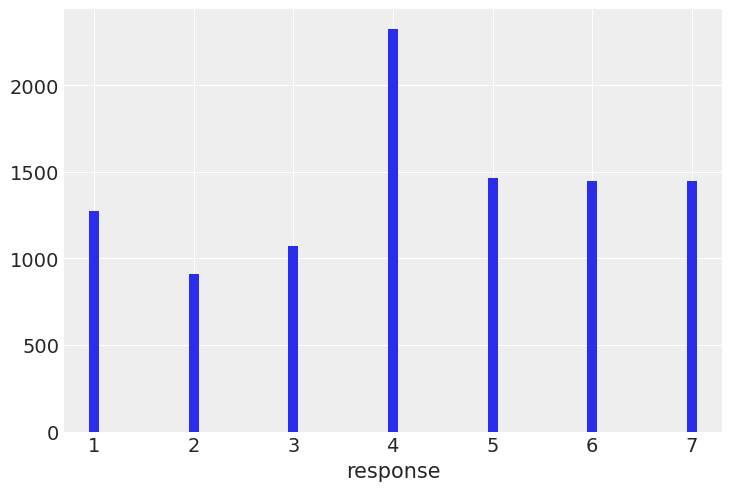

In [13]:
plt.hist(d.response, bins=jnp.arange(0.5, 8), rwidth=0.1)
plt.gca().set(xlim=(0.7, 7.3), xlabel="response")
plt.show()

### Code 12.14

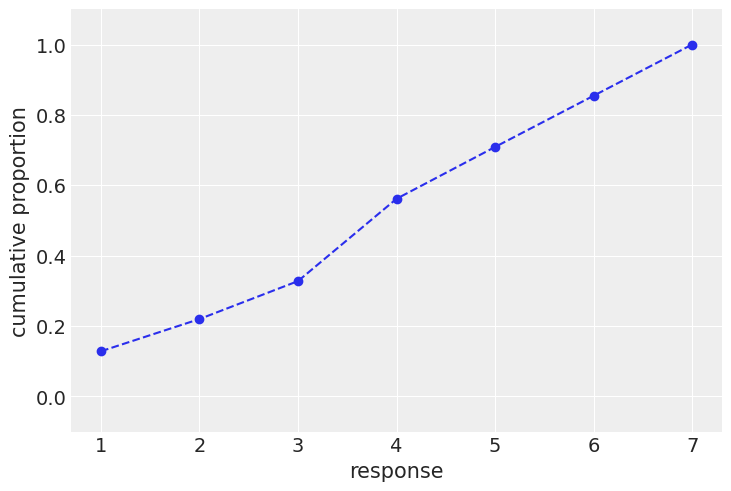

In [14]:
# discrete proportion of each response value
pr_k = d.response.value_counts().sort_index().values / d.shape[0]

# cumsum converts to cumulative proportions
cum_pr_k = jnp.cumsum(pr_k, -1)

# plot
plt.plot(range(1, 8), cum_pr_k, "--o")
plt.gca().set(xlabel="response", ylabel="cumulative proportion", ylim=(-0.1, 1.1))
plt.show()

### Code 12.15

In [15]:
logit = lambda x: jnp.log(x / (1 - x))  # convenience function
lco = logit(cum_pr_k)
lco

DeviceArray([-1.91609116, -1.26660559, -0.718634  ,  0.24778573,
              0.88986365,  1.76938091,         inf], dtype=float64)

### Code 12.16

In [16]:
def model(R):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=R)


m12_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_4.run(random.PRNGKey(0), R=d.response.values - 1)

**Note:** With single-precision (x32) computations, MCMC chains might get stuck when the initial values are badly generated. Changing the random seed can solve the issue but it is better to enable x64 mode at the beginning of our program (see `numpyro.enable_x64()` in the first cell).

### Code 12.17

In [17]:
def model(response):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    numpyro.sample("response", dist.OrderedLogistic(0, cutpoints), obs=response)


m12_4q = AutoLaplaceApproximation(
    model,
    init_loc_fn=init_to_value(
        values={"cutpoints": jnp.array([-2, -1, 0, 1, 2, 2.5])}
    ),
)
svi = SVI(model, m12_4q, optim.Adam(0.3), Trace_ELBO(), response=d.response.values - 1)
svi_result = svi.run(random.PRNGKey(0), 1000)
p12_4q = svi_result.params

100%|██████████| 1000/1000 [00:01<00:00, 917.76it/s, init loss: 20457.6601, avg. loss [951-1000]: 18551.5527]


### Code 12.18

In [18]:
m12_4.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
cutpoints[0]     -1.92      0.03     -1.92     -1.97     -1.87   1263.46      1.00
cutpoints[1]     -1.27      0.02     -1.27     -1.30     -1.23   2023.27      1.00
cutpoints[2]     -0.72      0.02     -0.72     -0.75     -0.69   2404.58      1.00
cutpoints[3]      0.25      0.02      0.25      0.22      0.28   2496.26      1.00
cutpoints[4]      0.89      0.02      0.89      0.85      0.93   2389.34      1.00
cutpoints[5]      1.77      0.03      1.77      1.73      1.82   2471.61      1.00

Number of divergences: 0


### Code 12.19

In [19]:
expit(jnp.mean(m12_4.get_samples()["cutpoints"], 0))

DeviceArray([0.1283027 , 0.21983528, 0.32767265, 0.56170334, 0.70883243,
             0.85439841], dtype=float64)

### Code 12.20

In [20]:
coef = jnp.mean(m12_4.get_samples()["cutpoints"], 0)
pk = jnp.exp(dist.OrderedLogistic(0, coef).log_prob(jnp.arange(7)))
pk

DeviceArray([0.1283027 , 0.09153258, 0.10783737, 0.23403069, 0.14712909,
             0.14556598, 0.14560159], dtype=float64)

### Code 12.21

In [21]:
jnp.sum(pk * jnp.arange(1, 8))

DeviceArray(4.19925519, dtype=float64)

### Code 12.22

In [22]:
coef = jnp.mean(m12_4.get_samples()["cutpoints"], 0) - 0.5
pk = jnp.exp(dist.OrderedLogistic(0, coef).log_prob(jnp.arange(7)))
pk

DeviceArray([0.08195697, 0.06400538, 0.08219762, 0.20919047, 0.15886489,
             0.18444583, 0.21933882], dtype=float64)

### Code 12.23

In [23]:
jnp.sum(pk * jnp.arange(1, 8))

DeviceArray(4.72969372, dtype=float64)

### Code 12.24

In [24]:
dat = dict(
    R=d.response.values - 1, A=d.action.values, I=d.intention.values, C=d.contact.values
)


def model(A, I, C, R=None):
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bI = numpyro.sample("bI", dist.Normal(0, 0.5))
    bC = numpyro.sample("bC", dist.Normal(0, 0.5))
    bIA = numpyro.sample("bIA", dist.Normal(0, 0.5))
    bIC = numpyro.sample("bIC", dist.Normal(0, 0.5))
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    BI = bI + bIA * A + bIC * C
    phi = numpyro.deterministic("phi", bA * A + bC * C + BI * I)
    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)


m12_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m12_5.run(random.PRNGKey(0), **dat)
m12_5.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
          bA     -0.47      0.05     -0.47     -0.55     -0.38    987.08      1.01
          bC     -0.34      0.07     -0.34     -0.46     -0.24   1070.75      1.00
          bI     -0.29      0.06     -0.29     -0.39     -0.20    927.26      1.00
         bIA     -0.43      0.08     -0.43     -0.55     -0.29   1126.29      1.00
         bIC     -1.23      0.10     -1.23     -1.40     -1.08   1142.96      1.00
cutpoints[0]     -2.63      0.05     -2.63     -2.71     -2.55    922.25      1.00
cutpoints[1]     -1.94      0.05     -1.94     -2.02     -1.87    956.10      1.01
cutpoints[2]     -1.34      0.04     -1.35     -1.42     -1.27    951.89      1.00
cutpoints[3]     -0.31      0.04     -0.31     -0.38     -0.24    951.96      1.00
cutpoints[4]      0.36      0.04      0.36      0.29      0.43   1048.47      1.00
cutpoints[5]      1.27      0.05      1.27      1.20      1.34    956.31      1.00

Nu

### Code 12.25

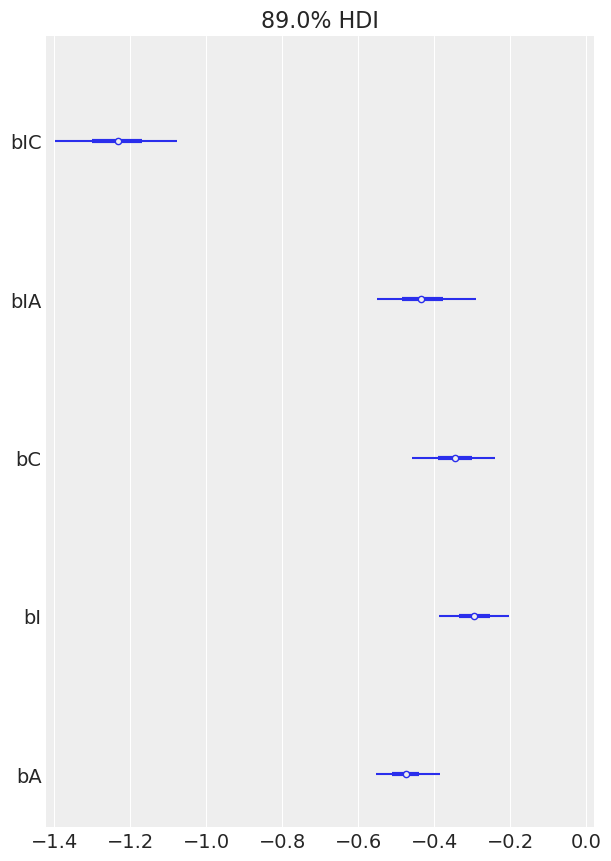

In [25]:
post = m12_5.get_samples(group_by_chain=True)
az.plot_forest(
    post, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, hdi_prob=0.89,
)
plt.gca().set(xlim=(-1.42, 0.02))
plt.show()

### Code 12.26

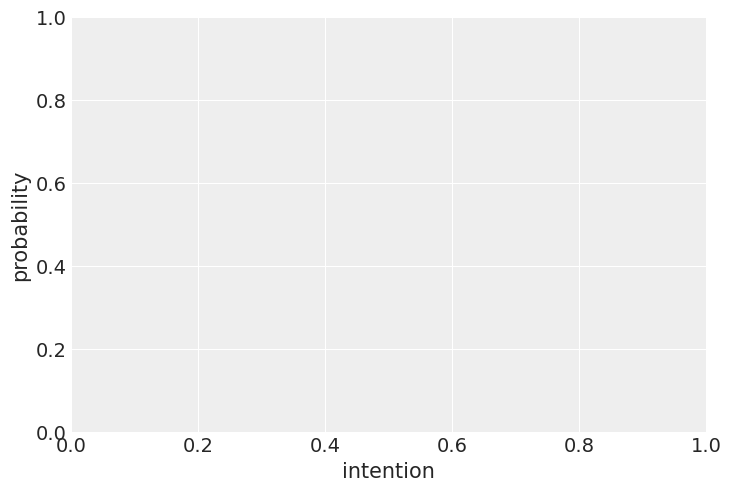

In [26]:
ax = plt.subplot(xlabel="intention", ylabel="probability", xlim=(0, 1), ylim=(0, 1))
fig = plt.gcf()

### Code 12.27

In [27]:
kA = 0  # value for action
kC = 0  # value for contact
kI = jnp.arange(2)  # values of intention to calculate over
pdat = dict(A=kA, C=kC, I=kI)
phi = Predictive(m12_5.sampler.model, m12_5.get_samples())(random.PRNGKey(1), **pdat)[
    "phi"
]

### Code 12.28

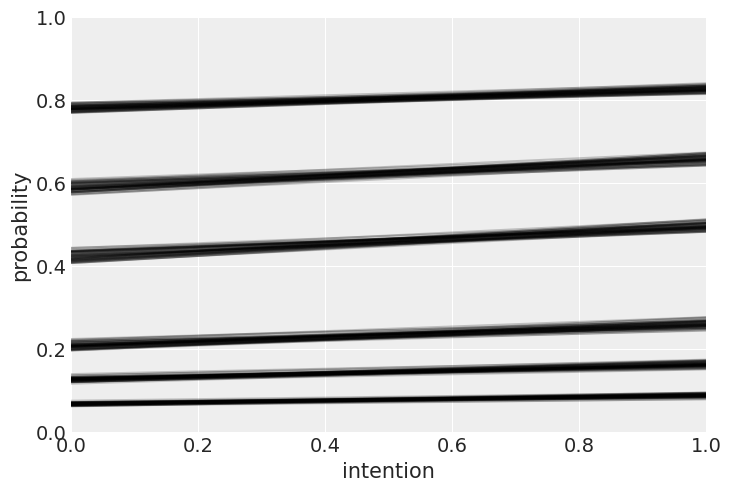

In [28]:
post = m12_5.get_samples()
for s in range(50):
    pk = expit(post["cutpoints"][s] - phi[s][..., None])
    for i in range(6):
        ax.plot(kI, pk[:, i], c="k", alpha=0.2)
fig

### Code 12.29

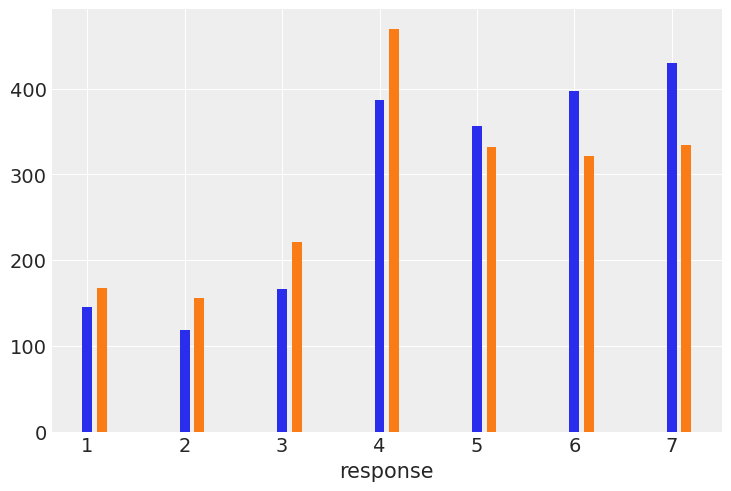

In [29]:
kA = 0  # value for action
kC = 0  # value for contact
kI = jnp.arange(2)  # values of intention to calculate over
pdat = dict(A=kA, C=kC, I=kI)
s = (
    Predictive(m12_5.sampler.model, m12_5.get_samples())(random.PRNGKey(1), **pdat)["R"]
    + 1
)
plt.hist(s[:, 0], bins=jnp.arange(0.5, 8), rwidth=0.1)
plt.hist(s[:, 1], bins=jnp.arange(0.65, 8), rwidth=0.1)
plt.gca().set(xlabel="response")
plt.show()

### Code 12.30

In [30]:
Trolley = pd.read_csv("../data/Trolley.csv", sep=";")
d = Trolley
d.edu.unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

### Code 12.31

In [31]:
edu_levels = [
    "Elementary School",
    "Middle School",
    "Some High School",
    "High School Graduate",
    "Some College",
    "Bachelor's Degree",
    "Master's Degree",
    "Graduate Degree",
]
cat_type = pd.api.types.CategoricalDtype(categories=edu_levels, ordered=True)
d["edu_new"] = d.edu.astype(cat_type).cat.codes

### Code 12.32

In [32]:
delta = dist.Dirichlet(jnp.repeat(2, 7)).sample(random.PRNGKey(1805), (10,))
delta

DeviceArray([[0.25509119, 0.03908582, 0.02062807, 0.07466964, 0.01564467,
              0.06088717, 0.53399344],
             [0.06188233, 0.16273207, 0.33820846, 0.14339588, 0.10220403,
              0.09596682, 0.09561042],
             [0.10517178, 0.26792887, 0.17099041, 0.0463058 , 0.09862729,
              0.19184056, 0.11913529],
             [0.13225867, 0.17854144, 0.27357335, 0.09591914, 0.20810338,
              0.08527108, 0.02633294],
             [0.06846251, 0.17774259, 0.13601505, 0.13269377, 0.23953351,
              0.01396916, 0.23158341],
             [0.10417249, 0.19923656, 0.10265471, 0.10296115, 0.30281302,
              0.08507872, 0.10308334],
             [0.17357477, 0.08437654, 0.29003704, 0.0621773 , 0.06377041,
              0.08843999, 0.23762396],
             [0.09415017, 0.13096043, 0.09720853, 0.02269312, 0.01563354,
              0.41263503, 0.22671918],
             [0.03496056, 0.02213823, 0.04275664, 0.17735326, 0.1310294 ,
              0.323299

### Code 12.33

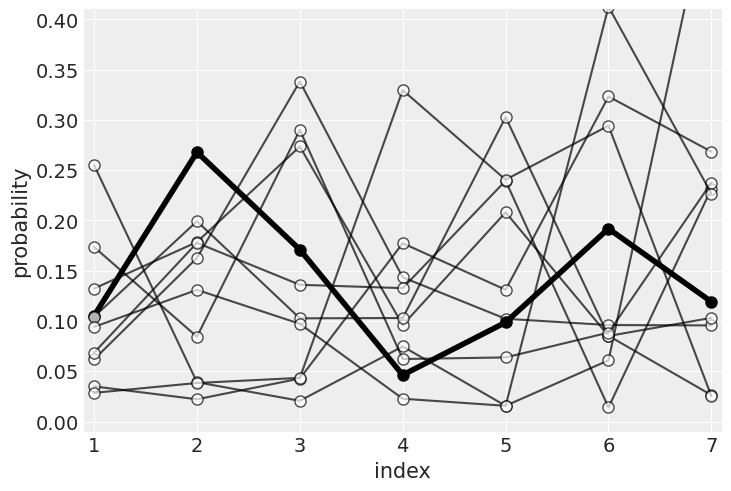

In [33]:
h = 3
plt.subplot(xlim=(0.9, 7.1), ylim=(-0.01, 0.41), xlabel="index", ylabel="probability")
for i in range(delta.shape[0]):
    if i + 1 == h:
        plt.plot(range(1, 8), delta[i], "ko-", ms=8, lw=4)
    else:
        plt.plot(range(1, 8), delta[i], "ko-", mfc="w", ms=8, lw=1.5, alpha=0.7)

### Code 12.34

In [34]:
dat = dict(
    R=d.response.values - 1,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
    E=d.edu_new.values,  # edu_new as an index
    alpha=jnp.repeat(2, 7),
)  # delta prior


def model(action, intention, contact, E, alpha, R):
    bA = numpyro.sample("bA", dist.Normal(0, 1))
    bI = numpyro.sample("bI", dist.Normal(0, 1))
    bC = numpyro.sample("bC", dist.Normal(0, 1))
    bE = numpyro.sample("bE", dist.Normal(0, 1))
    delta = numpyro.sample("delta", dist.Dirichlet(alpha))
    kappa = numpyro.sample(
        "kappa",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    delta_j = jnp.pad(delta, (1, 0))
    delta_E = jnp.sum(jnp.where(jnp.arange(8) <= E[..., None], delta_j, 0), -1)
    phi = bE * delta_E + bA * action + bI * intention + bC * contact
    numpyro.sample("R", dist.OrderedLogistic(phi, kappa), obs=R)


m12_6 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m12_6.run(random.PRNGKey(0), **dat)

### Code 12.35

In [35]:
m12_6.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        bA     -0.71      0.04     -0.71     -0.77     -0.64   1635.22      1.00
        bC     -0.96      0.05     -0.96     -1.04     -0.88   1691.41      1.00
        bE     -0.37      0.18     -0.35     -0.65     -0.09    872.59      1.00
        bI     -0.72      0.04     -0.72     -0.78     -0.66   1541.93      1.00
  delta[0]      0.26      0.15      0.23      0.03      0.48    782.74      1.00
  delta[1]      0.14      0.09      0.12      0.01      0.27   1592.20      1.00
  delta[2]      0.19      0.11      0.17      0.03      0.35   1486.17      1.00
  delta[3]      0.17      0.10      0.16      0.01      0.29   1077.97      1.00
  delta[4]      0.04      0.04      0.02      0.00      0.07    771.48      1.00
  delta[5]      0.09      0.06      0.08      0.01      0.16   1502.67      1.00
  delta[6]      0.12      0.07      0.10      0.01      0.22   1591.30      1.00
  kappa[0]     -3.13      0

### Code 12.36

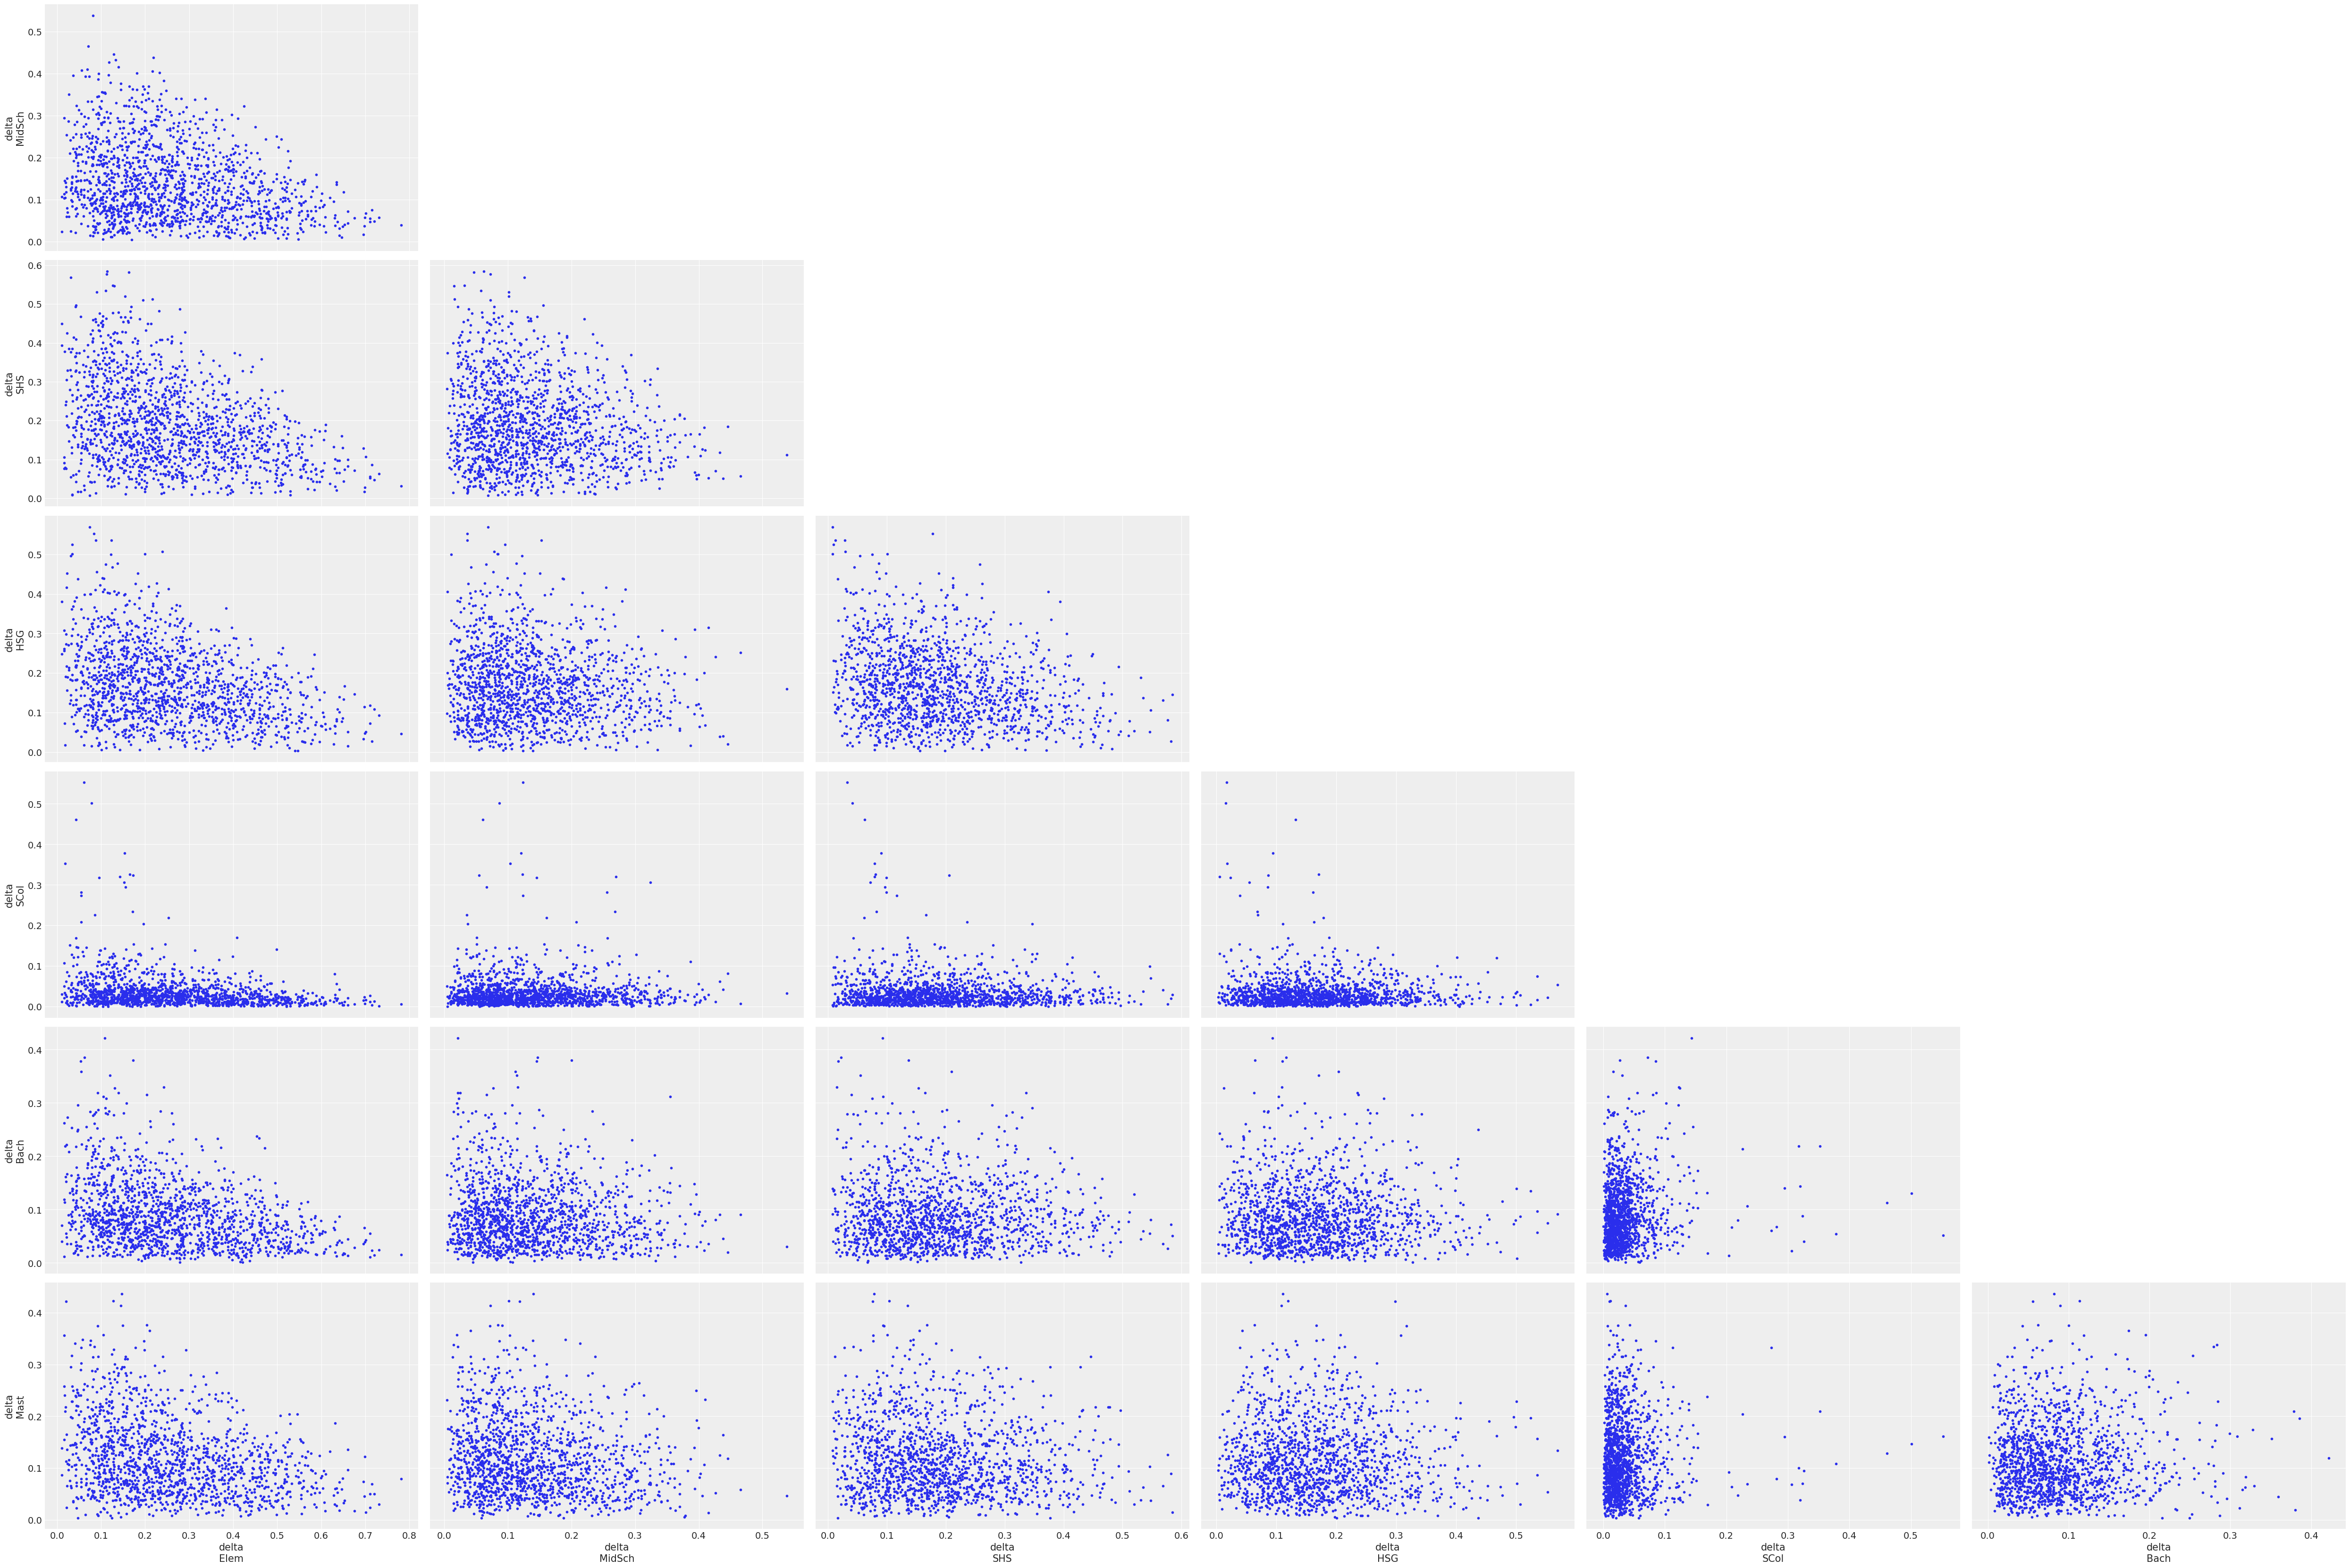

In [36]:
delta_labels = ["Elem", "MidSch", "SHS", "HSG", "SCol", "Bach", "Mast", "Grad"]
a12_6 = az.from_numpyro(
    m12_6, coords={"labels": delta_labels[:7]}, dims={"delta": ["labels"]}
)
az.plot_pair(a12_6, var_names="delta")
set_matplotlib_formats("png")

### Code 12.37

In [37]:
dat["edu_norm"] = d.edu_new.values / d.edu_new.max()


def model(edu_norm, action, intention, contact, y):
    bA = numpyro.sample("bA", dist.Normal(0, 1))
    bI = numpyro.sample("bI", dist.Normal(0, 1))
    bC = numpyro.sample("bC", dist.Normal(0, 1))
    bE = numpyro.sample("bE", dist.Normal(0, 1))
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    mu = bE * edu_norm + bA * action + bI * intention + bC * contact
    numpyro.sample("y", dist.OrderedLogistic(mu, cutpoints), obs=y)


m12_7 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m12_7.run(
    random.PRNGKey(0),
    dat["edu_norm"],
    dat["action"],
    dat["intention"],
    dat["contact"],
    dat["R"],
)
m12_7.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
          bA     -0.70      0.04     -0.70     -0.77     -0.64   1549.76      1.00
          bC     -0.96      0.05     -0.95     -1.04     -0.89   1476.79      1.00
          bE     -0.11      0.09     -0.11     -0.26      0.03    890.47      1.00
          bI     -0.72      0.04     -0.72     -0.77     -0.66   1824.04      1.00
cutpoints[0]     -2.90      0.08     -2.91     -3.03     -2.78    894.88      1.00
cutpoints[1]     -2.22      0.07     -2.22     -2.33     -2.09    947.26      1.00
cutpoints[2]     -1.64      0.07     -1.64     -1.75     -1.52    959.18      1.00
cutpoints[3]     -0.62      0.07     -0.62     -0.73     -0.50    951.74      1.00
cutpoints[4]      0.05      0.07      0.05     -0.06      0.17   1015.97      1.00
cutpoints[5]      0.95      0.07      0.96      0.84      1.08   1116.76      1.00

Number of divergences: 0


### Code 12.38

In [38]:
Hurricanes = pd.read_csv("../data/Hurricanes.csv", sep=";")

<!-- NAVIGATION -->
< [Chapter 11. God Spiked the Integers](11-god-spiked-the-integers.html) | [Chapter 13. Models With Memory](13-models-with-memory.html) >